In [1]:
# import jax.numpy as np
from discopy import Tensor, CircuitFunctor
from discopy import Ob, Ty, Box, Id, Swap, Diagram, Dim, Tensor, Cup, Cap, tensor, Word, pregroup
from discopy.quantum import qubit, H, Id, CX, QuantumGate, Ket, Bra, Measure, Discard, SWAP,  circuit, sqrt, X, Rx, Rz, Ry, Circuit
from discopy.grammar import brute_force, eager_parse
from discopy.quantum.circuit import IQPansatz

import numpy as np
from jax import jit
import jax.numpy as jnp
Tensor.np = jnp
from noisyopt import minimizeSPSA

import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import pickle
import requests
import time

# Data Preprocessing

## Full Data

In [2]:
lines_raw = open("data/data_earth.txt", "r").readlines()
lines_raw = [s.replace('\n','') for s in lines_raw]
labels = []
lines = []
words = []
l = 0;
for i in range(len(lines_raw)):
    if len(lines_raw[i])==0:
        l = 1;
    else:
        lines.append(lines_raw[i].replace('.',''))
        labels.append(l)
        words_line = lines_raw[i].replace('.','').split(' ')
        words= words + words_line
print(lines)
print(labels)

lines = np.array(lines)
labels = np.array(labels)

['Earth is flat', 'Earth is not round', 'Earth does not rotates', 'Sun revolves around Earth', 'Earth does not revolves around Sun', 'Earth has no poles', 'Earth has no south pole', 'Earth has no north pole', 'Arctic is in the center', 'Antartic is the boundary', 'Earth has a boundary', 'Earth is surrounded by a dome', 'Earth is round', 'Earth is not flat', 'Earth rotates', 'Earth revolves around the Sun', 'Sun does not revolves around Earth', 'Earth has two poles', 'Earth has no center', 'Earth has no boundary', 'Arctic is in the north pole', 'Antartic is in the south pole', 'Earth is surrounded by atmosphere']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


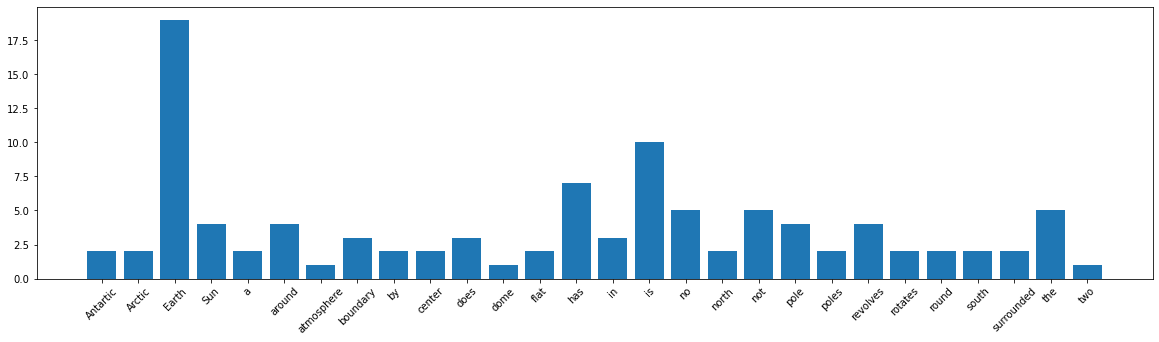

In [3]:
dictionnary, counts = np.unique(words,return_counts=True)
plt.figure(figsize=(20,5))
plt.bar(np.arange(len(dictionnary)),counts,tick_label=dictionnary)
plt.xticks(rotation = 45);

## Reduced Data : `x`  is `y`

## subset selection : earth is flat, Artic is North, Antartic is South

In [4]:
my_nouns = ['Earth','Antartic','Artic','north','south','flat','round']
my_trans_verbs = ['is']

In [5]:
s, n = Ty('s'), Ty('n')

In [6]:
vocab_noun = [Word(noun, n) for noun in my_nouns]
vocab_verb = [Word(trans,n.r@s@n.l) for trans in my_trans_verbs]

### Generate Diagrams

In [7]:
def brute_pregroup(vocab):
    """
    Given a vocabulary, outputs random grammatical sentences.
    """
    grammar = Cup(n,n.r)@Id(s)@Cup(n.l,n)
    for i1 in range(len(vocab[0])):
#         print(vocab[0][i1])
        for i2 in range(len(vocab[1])):
#             print(vocab[1][i2])
            for i3 in range(len(vocab[0])):
#                 print(vocab[0][i3])
                sentence = vocab[0][i1] @ vocab[1][i2] @ vocab[0][i3]
#                 print(sentence)
                yield sentence >> grammar


In [8]:
def random_pregroup(vocab, target=[0,1,0],grammar = Cup(n,n.r)@Id(s)@Cup(n.l,n)):
    """
    Given a vocabulary, outputs random grammatical sentences.
    """
    sentence = []
    diagram = []
    for t in target:
        word = random.choice(vocab[t])
        sentence = sentence @ word
    yield sentence >> grammar

In [9]:
def random_sentence(vocab, target=Ty('s')):
    """
    Given a vocabulary, outputs random grammatical sentences.
    """
    
    while 1:
        test = [()]
        stop = 0
        for words in test:
            random.shuffle(vocab)
            for word in vocab:
                try:
                    yield eager_parse(*(words + (word, )), target=target)
                    stop = 1
                except NotImplementedError:
                    pass
                test.append(words + (word, ))
                if stop ==1:
                    break
            if stop ==1:
                break
            

### Create training data : Manual Labelling tool

choose option : complete or random labelling

In [10]:
# gen = random_pregroup([vocab_noun , vocab_verb])
# gen = random_sentence(vocab_noun + vocab_verb)
gen = brute_pregroup([vocab_noun , vocab_verb])

In [ ]:
N_training = 1000
labels = []
diagrams = []
while np.sum(np.array(labels))<N_training:
    diagram = next(gen)
    if (diagram not in diagrams) or diagrams is None:
        diagram.draw()
        label = input()
        clear_output()
        if ((label == '1') or (label == '0')):
            labels = labels + [int(label)]
            diagrams = diagrams + [diagram]

save and load existing ones

In [ ]:
# pickle.dump([diagrams,labels], open('data/store.pckl', 'wb'))
# pickle.dump([diagrams,labels], open('data/store_brute.pckl', 'wb'))

In [12]:
# [diagrams,labels] = pickle.load(open('data/store.pckl', 'rb'))
[diagrams,labels] = pickle.load(open('data/store_brute.pckl', 'rb'))

In [ ]:
print(diagrams)
print(labels)

In [49]:
sentences = [d.boxes[0].name + " " + d.boxes[1].name + " " + d.boxes[2].name for d in diagrams]

# Diagram to Qubit : Functor Definition

## Ansatz definition

The most generic ansatz were chosen :
* nouns : one qbit transformation, Euler representation
* verb : two qubit transformation SU4

In [13]:
def transitive_ansatz(params):
    return Ket(0, 0) >> Rz(0.5) @ Rz(0.5) >> Ry(0.5) @ Id(qubit)\
        >> CX >> IQPansatz(1,params[0:3]) @ IQPansatz(1,params[3:6]) >> CX\
        >> Ry(-0.5) @ Id(qubit) >> Rz(-0.5) @ Rz(-0.5) 

def word_ansatz(params):
    return Ket(0) >> IQPansatz(1,params)

## Functor definition

define the dictionary for the Functor

In [14]:
noun_dict = lambda params,nouns : {Word(nouns[i], n):word_ansatz(jnp.asarray(params)[3*i:3*i+3]) for i in range(len(nouns))}

trans_dict = lambda params,trans_verbs : {Word(trans_verbs[i], n.r@s@n.l):transitive_ansatz(jnp.asarray(params)[6*i:6*i+6]) for i in range(len(trans_verbs))}

ar = lambda params: {**noun_dict(params[0:3*len(my_nouns)],my_nouns) , **trans_dict(params[3*len(my_nouns):],my_trans_verbs)}

define Functor

In [15]:
ob = {s: 0, n: 1}
F = lambda params: CircuitFunctor(ob, ar(params))

random initial parameters, with length :
* 3 times the number of nouns 
* 6 times the number of verbs

In [16]:
params0 = 2*np.random.random(len(my_nouns)*3+len(my_trans_verbs)*6)
params0 = jnp.array(params0,dtype='float32')

## Display models

### Noun example

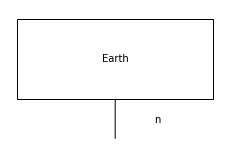

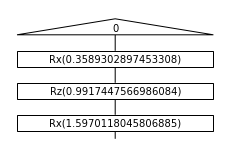

DeviceArray([-0.99010336+0.01901004j,  0.01763722-0.13792363j], dtype=complex64)

In [17]:
vocab_noun[0].draw(figsize=(3, 2))
F(params0)(vocab_noun[0]).draw(figsize=(3, 2))
F(params0)(vocab_noun[0]).eval().array

### Verb example

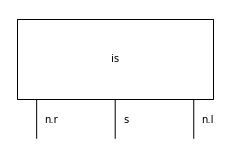

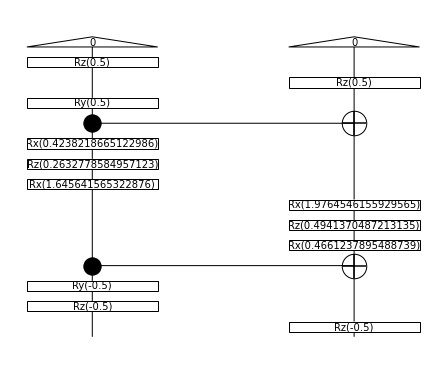

DeviceArray([[ 0.02049536+0.01957901j, -0.6502614 +0.57597333j],
             [-0.4746919 -0.13790928j, -0.00319438+0.01580993j]],            dtype=complex64)

In [18]:
vocab_verb[0].draw(figsize=(3, 2))
F(params0)(vocab_verb[0]).draw(figsize=(6, 5))
F(params0)(vocab_verb[0]).eval().array

### sentence example

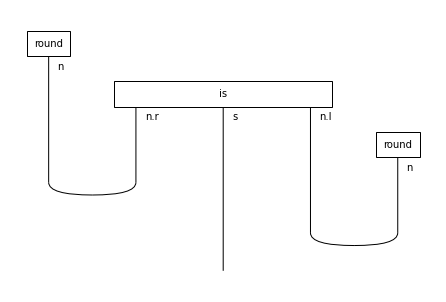

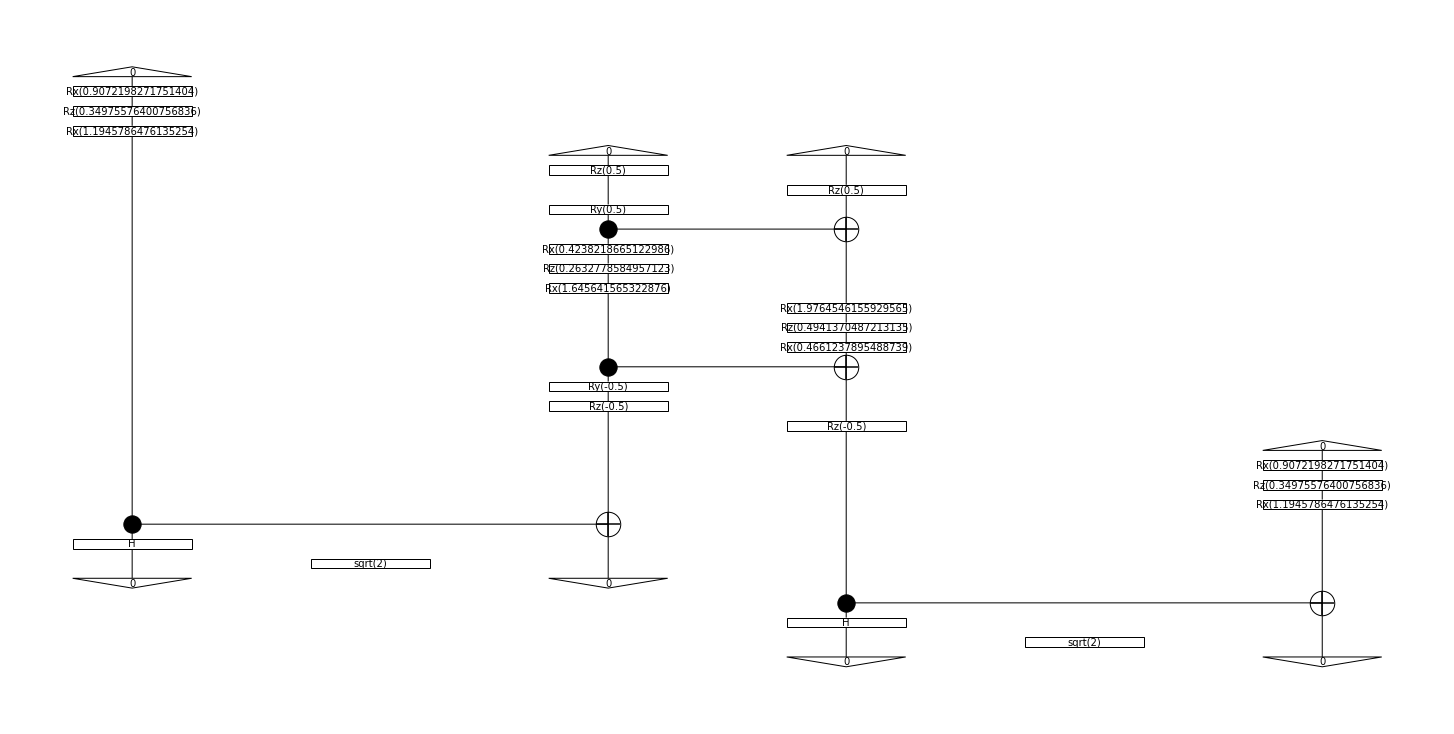

[0.28850555-0.5366103j]
[0.37118608]


In [19]:
diagram0 = diagrams[-1]
diagram0.draw()
F(params0)(diagram0).draw(figsize=(20,10))
print(F(params0)(diagram0).eval().array)
print(F(params0)(diagram0).measure())

# Training

## pre-processing data

In [61]:
N = len(labels)
N_1 = int(np.sum(labels==1))
N_0 = int(np.sum(labels==0))

In [62]:
print(f"{N_true} sentences are true {N_false} sentences are false")

13 sentences are true 36 sentences are false


Lets remove the class imbalance 

In [88]:
percent = 0.75 # percent of sentences to be used
N_t = int(percent*min(N_1,N_0))
np.random.seed(2021)
ind_t_1 = np.random.choice(np.where(labels==1)[0],N_t,replace=False)
ind_t_0 = np.random.choice(np.where(labels==0)[0],N_t,replace=False)
ind_t = np.hstack((ind_t_1 , ind_t_0))
ind_v = np.delete(np.arange(N),ind_t)
print(f"{len(ind_t)} samples taken for training, {len(ind_v)} samples taken as testing")

18 samples taken for training, 31 samples taken as testing


In [89]:
train_diagrams = [diagrams[i] for i in ind_t]
test_diagrams = [diagrams[i] for i in ind_v]

labels = jnp.array(labels)

train_labels = labels[ind_t]
dev_labels = []
test_labels = labels[ind_v]

In [90]:
print("train data")
for i in ind_t:
    print(f"{sentences[i]} :  {labels[i]}")

train data
Earth is round :  1
round is Earth :  1
Antartic is Antartic :  1
north is north :  1
flat is flat :  1
Antartic is south :  1
south is Antartic :  1
round is round :  1
north is Artic :  1
Artic is Antartic :  0
Earth is Antartic :  0
flat is round :  0
south is round :  0
north is Earth :  0
south is north :  0
Earth is flat :  0
Antartic is flat :  0
flat is Artic :  0


## define functions : prediction, loss and accuracy

### definition

In [112]:
def accuracy(predicts, labels):
#     acc = jnp.mean(jnp.array([jnp.round(predict) == label for predict,label in zip(predicts,labels)]))
    acc = jnp.mean(jnp.round(predicts) == labels)
    return acc

In [113]:
def BCE_loss(predicts, labels):
#     cost = -jnp.mean(jnp.array([label * jnp.log(predict) + (1 - label)*jnp.log(1-predict) for predict,label in zip(predicts,labels)]))
    cost = -jnp.mean(labels * jnp.log(predicts) + (1 - labels)*jnp.log(1-predicts))
    return cost

In [114]:
def make_pred_fn(diagrams):
    pred_fn = lambda params: jnp.array([jnp.abs(F(params)(d).eval().array[0]) for d in diagrams])
    return pred_fn

### testing

In [115]:
p = make_pred_fn(diagrams)(params0)
predicts_best = jnp.array([0.1 if l ==0 else 0.9 for l in labels])
predicts_worst = jnp.array([0.1 if l ==1 else 0.9 for l in labels])

In [95]:
print(BCE_loss(p,labels))
print(BCE_loss(predicts_best,labels))
print(BCE_loss(predicts_worst,labels))

0.67570436
0.10536053
2.3025851


In [96]:
print(accuracy(p,labels))
print(accuracy(predicts_best,labels))
print(accuracy(predicts_worst,labels))

0.63265306
1.0
0.0


### compiling with JIT

In [97]:
train_pred_fn = jit(make_pred_fn(train_diagrams))
test_pred_fn = jit(make_pred_fn(test_diagrams))


x0 = params0
print("Performing Just-In-Time compilation, this may take a while...")
print(train_pred_fn(x0))
print(test_pred_fn(x0))

Performing Just-In-Time compilation, this may take a while...
[0.6363612  0.28968117 0.56861764 ... 0.39706895 0.44219372 0.33015972]
[0.14410427 0.47320482 0.517517   ... 0.26008788 0.46213198 0.10377222]


In [134]:
def make_cost_fn(pred_fn, labels):
    costs = []
    accs = []
    params_list = []
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = BCE_loss(predictions, labels)
        acc = accuracy(predictions, labels)
        costs.append(cost)
        accs.append(acc)
        params_list.append(params)

        return cost

    return cost_fn, costs, accs, params_list

In [135]:
# Rerun this cell onwards, so you can reuse the JITed prediction functions
train_cost_fn, train_costs, train_accs, spsa_params = make_cost_fn(train_pred_fn, train_labels)
test_cost_fn, test_costs, test_accs, _ = make_cost_fn(test_pred_fn, test_labels)

In [136]:
print(train_cost_fn(x0))
print(test_cost_fn(x0))

0.7757678
0.61760294


## Optimisation

In [137]:
tic = time.time()
O = minimizeSPSA(train_cost_fn, x0=x0, a=0.13, c=0.1, niter=500, callback=test_cost_fn)
toc = time.time()
print(f"It took {int(toc-tic)} seconds to run the optimisation.")
print(O)
paramsf = O.x

It took 7 seconds to run the optimisation.
     fun: DeviceArray(0.32654235, dtype=float32)
 message: 'terminated after reaching max number of iterations'
    nfev: 1000
     nit: 500
 success: True
       x: DeviceArray([0.4749705 , 1.1325157 , 1.8161731 , ..., 1.9908625 ,
             0.50766045, 0.56365097], dtype=float32)


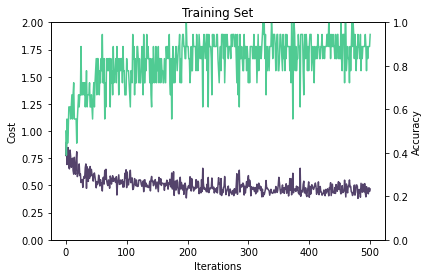

In [138]:
fig, ax1 = plt.subplots()
ax1.plot(train_costs[::2], color='#54436B')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Training Set')
ax1.set_ylim([0,2])

ax2 = ax1.twinx()
ax2.plot(range(len(train_accs[::2])),train_accs[::2], color='#50CB93')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0,1])
plt.show()

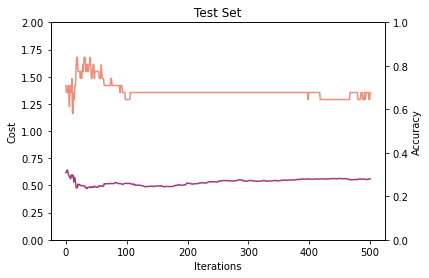

In [139]:
fig, ax1 = plt.subplots()
ax1.plot(test_costs, color='#A03C78')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Test Set')
ax1.set_ylim([0,2])

ax2 = ax1.twinx()
ax2.plot(test_accs, color='#ED8E7C')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0,1])
plt.show()

# Display Results

## Nouns

### Nouns embedding

In [140]:
# get qubit embedding of each noun
noun_vec = np.array([F(paramsf)(noun).eval().array for noun in vocab_noun])
# compute density matrix |x><x|
rhos = np.matmul(np.expand_dims(noun_vec,axis=2),np.expand_dims(noun_vec.conjugate(),axis=1))

In [141]:
# nouns on the bloch sphere
bloch_u =  2*np.real(rhos[:,1,0])
bloch_v =  2*np.imag(rhos[:,1,0])
bloch_w =  np.real(rhos[:,0,0]-rhos[:,1,1])

In [142]:
# %matplotlib notebook
%matplotlib inline

### Bloch Sphere

In [143]:
# Create a sphere
phi, theta = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
x = np.sin(phi)*np.cos(theta)
y = np.sin(phi)*np.sin(theta)
z = np.cos(phi)

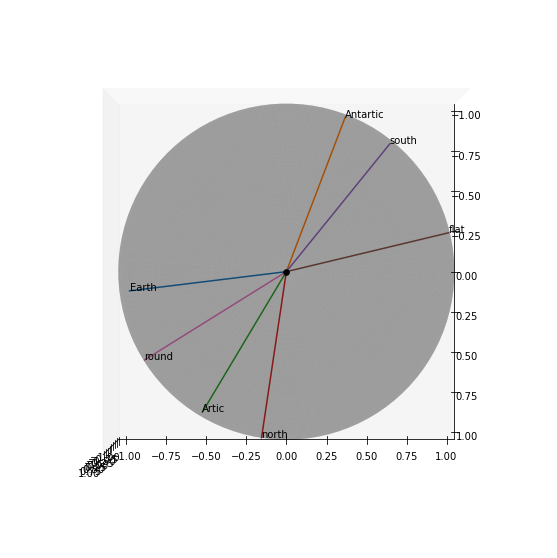

In [145]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.grid(False)
ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='k', alpha=0.2, linewidth=0)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

ax.scatter(0, 0, 0,c='k',s=30)

for i,noun in enumerate(my_nouns):
    plt.plot([0,bloch_u[i]],[0,bloch_v[i]],[0,bloch_w[i]])
    ax.text(bloch_u[i], bloch_v[i], bloch_w[i],noun)

ax.view_init(90, 0)

### projection

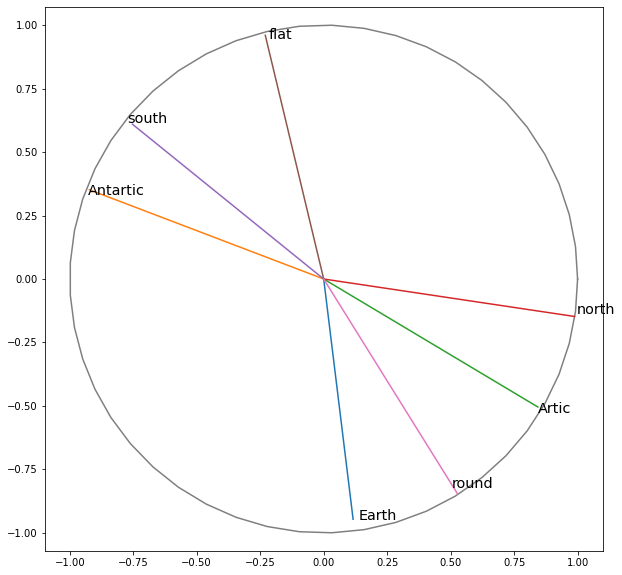

In [146]:
fig = plt.figure(figsize=(10,10))
t = np.linspace(0,2*np.pi)
plt.plot(np.cos(t),np.sin(t),'k',alpha=0.5)
plt.axis("equal")
for i,noun in enumerate(my_nouns):
    plt.plot([0,bloch_u[i]],[0,bloch_v[i]])
    plt.text(bloch_u[i]+(random.random()-0.5)*0.05, bloch_v[i]+(random.random()-0.5)*0.05,noun,fontsize='x-large')

### Noun Distance Matrix

In [147]:
bloch = np.vstack((bloch_u,bloch_v,bloch_w))
dist = np.sum(np.expand_dims(bloch,axis=1)*np.expand_dims(bloch,axis=2) ,axis=0)

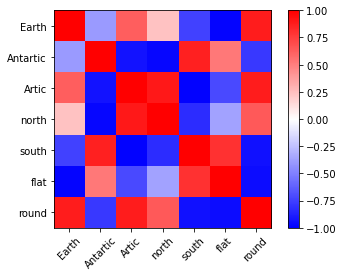

In [148]:
plt.imshow(dist,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(len(my_nouns)),labels=my_nouns)
plt.yticks(range(len(my_nouns)),labels=my_nouns)
plt.colorbar()
plt.xticks(rotation = 45);

## Verb : "is"

In [149]:
is_encoded = np.array(F(paramsf)(vocab_verb[0]).eval().array.flatten())

In [151]:
print("Amplitude :")
print(np.abs(is_encoded))
print("Angle :")
print(np.angle(is_encoded))

Amplitude :
[0.15473855 0.66493607 0.7116792  0.16561618]
Angle :
[-2.887299   1.8313429  2.229539  -2.4891033]
